In [ ]:
import sys
from IPython.display import Audio, display, HTML
display(HTML("<style>.container { width:97.5% !important; }</style>"))

In [ ]:
sys.path.append("/mnt/storage/home/kpsaraeva/.local/lib/python3.6/site-packages/pyofss")

In [ ]:
sys.path

In [1]:
import os.path
import numpy as np
from itertools import cycle
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import pyarrow as pa

from pyofss.field import energy, max_peak_params, spectrum_width_params
from pyofss import Domain, System, Gaussian, Fibre, Filter, Splitter, FibrePlotter
from pyofss import temporal_power, spectral_power, lambda_to_nu, nu_to_lambda
from pyofss import single_plot, map_plot, waterfall_plot, labels
from pyofss import Storage

from pyofss.domain import lambda_to_omega
from pyofss.modules.nonlinearity import calculate_gamma

from scipy.signal import find_peaks, peak_widths
from scipy.optimize import curve_fit


OpenclFibre is not activated, check if pyopencl and reikna modules are installed


In [2]:
import matplotlib
import matplotlib.pyplot as plt
from pyofss import Storage, FibrePlotter
from pyofss import labels
import matplotlib.gridspec as gridspec
matplotlib.rcParams['savefig.dpi'] = 300
matplotlib.rcParams["figure.dpi"] = 100
%matplotlib widget

In [108]:
def get_caption(folder_name):
    def sorting_func(name, param_string):
                name = name.split(f"_{param_string}_", 1)[1]
                sub = name.split("_", 1)[1] if (len(name.split("_", 1)) > 0) else ""
                name = name.replace(sub, "")
                name = name.replace("_", "")
                return float(name)
    caption =  f"Esat_1 = {sorting_func(folder_name, 'Esat_1')}, Esat_2 = {sorting_func(folder_name, 'Esat_2')}, La_1 = {sorting_func(folder_name, 'La_1')}, La_2 = {sorting_func(folder_name, 'La_2')}"       
    return caption


def draw_heat_map(df, domain, is_temporal=True, prominence=0.005, title="laser", subplot_spec=None, fig=None):
    if (is_temporal):
        x = domain.t
        x_label = labels["t"]
    else: 
        x = domain.nu
        x_label = labels["nu"]
    y = df.values
    z = df.index.get_level_values('z [mm]').values
    d_x = abs(x[1] - x[0])
    plotter = FibrePlotter(x, y, z, x_label, labels["P_t"], labels["z"])
    plotter.draw_heat_map(0, prominence=prominence, is_temporal=is_temporal, subplot_spec=subplot_spec, fig=fig, title=title, vmin=0)


def draw_double_plot(df, subplot_spec=None, fig=None, is_temporal = True):
    if (fig and subplot_spec is not None):
        inner = gridspec.GridSpecFromSubplotSpec(1, 1,
                                                    subplot_spec=subplot_spec, wspace=0.1, hspace=0.1)
        ax1 = plt.subplot(inner[0, 0])
    else:
        fig, ax1 = plt.subplots(figsize=(30, 6))

    color = 'tab:red'
    ax1.set_xlabel(labels["z"])

    if (is_temporal):
        ax1.set_ylabel(labels["t"], color=color)
    else:
        ax1.set_ylabel(labels["nu"], color=color)

    ax1.plot(df.index.get_level_values(
        'z [mm]').values, df["duration"].values, color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    # Adding Twin Axes to plot using dataset_2
    ax2 = ax1.twinx()

    color = 'tab:green'

    if (is_temporal):
        ax2.set_ylabel(labels["P_t"], color=color)
    else:
        ax2.set_ylabel(labels["P_nu"], color=color)
        
    ax2.plot(df.index.get_level_values(
        'z [mm]').values, df["max_value"].values, color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    plt.show()


def get_duration(P, d_x, prominence = 0.01):
    heigth_fwhm, fwhm, left_ind, right_ind = max_peak_params(
        P, prominence=prominence)
    return fwhm*d_x

def get_duration_spec(P, d_x, prominence = 0.0001):
    heigth_fwhm, fwhm, left_ind, right_ind = spectrum_width_params(
        P, prominence=prominence)
    return abs(fwhm)*d_x

def gaussian(x, a, x0, sigma):
    return a*np.exp(-((x-x0)**2)/(2*sigma**2))

def field_animation(df, domain, path_to_animation, is_temporal=True):
    if (is_temporal):
        x = domain.t
        x_label = labels["t"]
    else: 
        x = domain.nu
        x_label = labels["nu"]
    y = df.values
    z = df.index.get_level_values('z [mm]').values
    
    plotter = FibrePlotter(x, y, z, x_label, labels["P_t"], labels["z"])
    anim = plotter.draw_animation()
    anim.save(path_to_animation, fps=100, extra_args=['-vcodec', 'libx264'])

def  get_laser_info(df_laser, domain, cycle, caption, path_to_graph, is_temporal):
    if (is_temporal):
        additive = "temp"
        prominence = 0.1
    else:
        additive = "spec"
        prominence = 0.0001
    fig = plt.figure(figsize=(20, 10))
    outer = gridspec.GridSpec(2, 1, wspace=0.1, hspace=0.2)   
    characteristic = ["max_value", "duration"]
    iterables = [characteristic]
    index = pd.MultiIndex.from_product(iterables,  names=["charact"]) 
    df_results = pd.DataFrame(index=df_laser.index, columns=index)
    draw_heat_map(df_laser.loc[(cycle)], domain, is_temporal, prominence=prominence, title=caption, subplot_spec=outer[0], fig=fig)

    if (is_temporal):
        x = domain.t
        d_x = abs(x[1] - x[0])
        df_results['max_value'] = df_laser.max(axis=1).values
        df_results['duration'] = df_laser.apply(lambda row: get_duration(row, d_x, prominence), axis=1).values
        draw_double_plot(df_results.loc[(cycle)], outer[1], fig)
    else:
        x = domain.nu
        d_x = abs(x[1] - x[0])
        df_results['duration'] = df_laser.apply(
            lambda row: get_duration_spec(row, d_x, prominence), axis=1).values
        draw_double_plot(df_results.loc[(cycle)], outer[1], fig)
        
    fig.savefig(os.path.join(path_to_graph, f"info_{cycle}_{additive}.png"))

    anim = field_animation(
        df_laser.loc[(cycle)], domain, os.path.join(path_to_graph,f"animation_{cycle}_{additive}.mp4"), is_temporal)
    return df_results


def get_output_field(df_laser, last_cycle):
    z_output = df_laser.index.get_level_values('z [mm]').values[-1]
    last_fibre = df_laser.loc[(last_cycle, "5_active_fibre")]
    z_output = last_fibre.index.get_level_values('z [mm]').values[-1]
    output_field = last_fibre.loc[(z_output)]
    return output_field


In [4]:
labels

{'t': 'Time, $\\t \\, (ps)$',
 'nu': 'Frequency, $\\nu \\, (THz)$',
 'Lambda': 'Wavelength, $\\lambda \\, (nm)$',
 'P_t': 'Power, $|A(z, t)|^2 \\, (W)$',
 'P_nu': 'Power, $|\\tilde{A}(z, \\nu)|^2 \\, (a.u.)$',
 'P_lambda': 'Power, $|\\tilde{A}(z, \\lambda|^2 \\, (a.u.)$',
 'z': 'Fibre length, $z \\, (km)$',
 'phi': 'Phase, $\\phi(t) \\, (rad)$',
 'chirp': 'Frequency chirp, $\\delta \\omega \\, (rad / ps)$',
 't_normal': 'Normalised time, $\\frac{t}{T_0}$',
 'xi': 'Normalised distance, $\\xi = \\frac{z}{L_D}$',
 'xi_prime': "Normalised distance, $\\xi' = \\frac{z}{L_D'}$",
 'inst_nu': 'Inst. frequency, $\\nu \\, (THz)$'}

In [6]:
result_dir = 'results'
result_list = os.listdir(result_dir)
lasers_temp_files = []
lasers_spec_files = []
lasers_params = []
path_to_graphs = []
is_temporal = []
for i in range(len(result_list)):
    dir_name = os.path.join(result_dir, result_list[i])
    laser_list = os.listdir(dir_name)
    for j in range(len(laser_list)):
        obj = laser_list[j]
        if (obj.endswith('temp.csv') or obj.endswith('spec.csv')):
            if not (result_list[i] in lasers_params):
                lasers_params.append(result_list[i])
                path_to_graphs.append(os.path.join(dir_name, "graph"))
        if (obj.endswith('temp.csv')):
            lasers_temp_files.append(os.path.join(dir_name, obj))
        if (obj.endswith('spec.csv')):
            lasers_spec_files.append(os.path.join(dir_name, obj))



In [ ]:
results_temp = []

domain = Domain(samples_per_bit=2**14, bit_width=200.0,
                total_bits=1, centre_nu=lambda_to_nu(1035))
                
for i in range(len(lasers_temp_files)):
    df = pd.read_csv(lasers_temp_files[i], index_col=[0, 1, 2])
    results_temp.append(get_laser_info(df, domain, "cycle9", get_caption(lasers_params[i]), path_to_graphs[i], True))

In [ ]:
domain = Domain(samples_per_bit=2**14, bit_width=200.0,
                total_bits=1, centre_nu=lambda_to_nu(1035))
                
results_spec = []

for i in range(len(lasers_spec_files)):
    df = pd.read_csv(lasers_spec_files[i], index_col=[0, 1, 2])
    results_spec.append(get_laser_info(df, domain, "cycle9", get_caption(lasers_params[i]), path_to_graphs[i], False))

In [7]:
df_test_graphs = pd.read_csv(lasers_spec_files[0], index_col=[0, 1, 2])

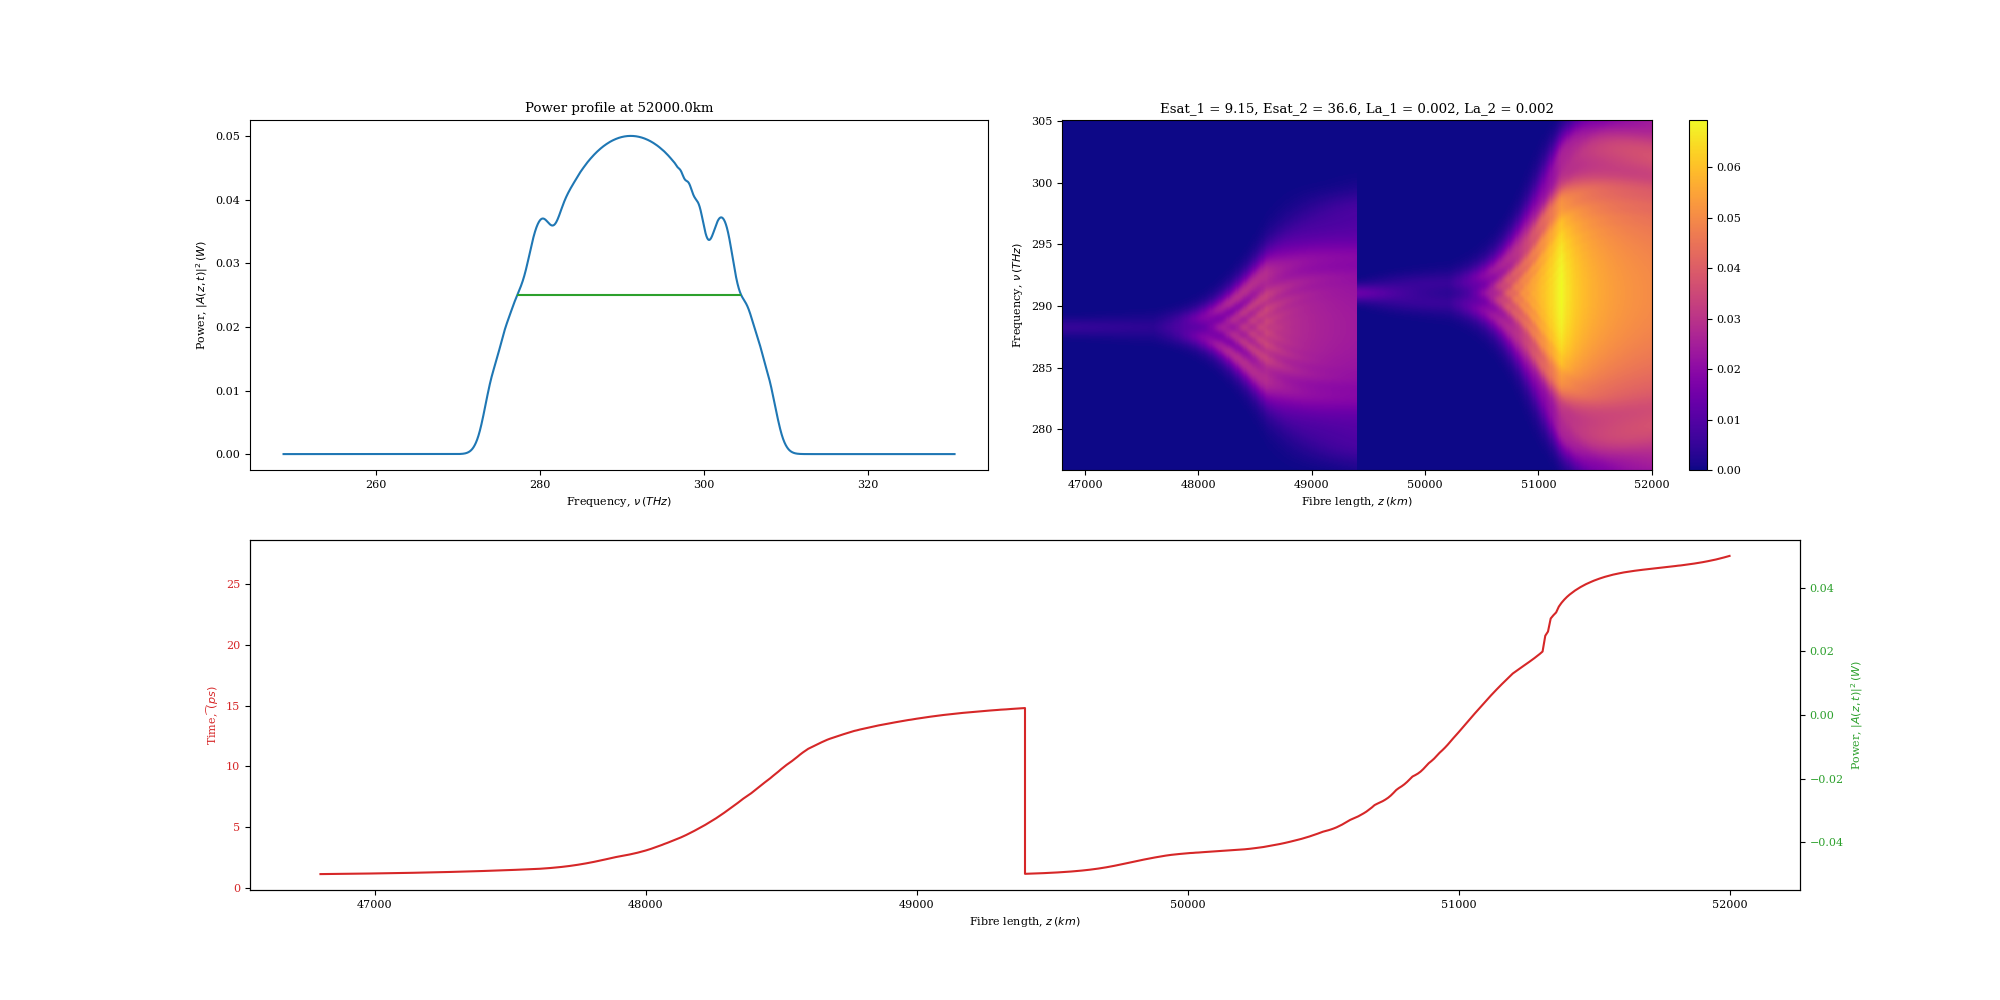

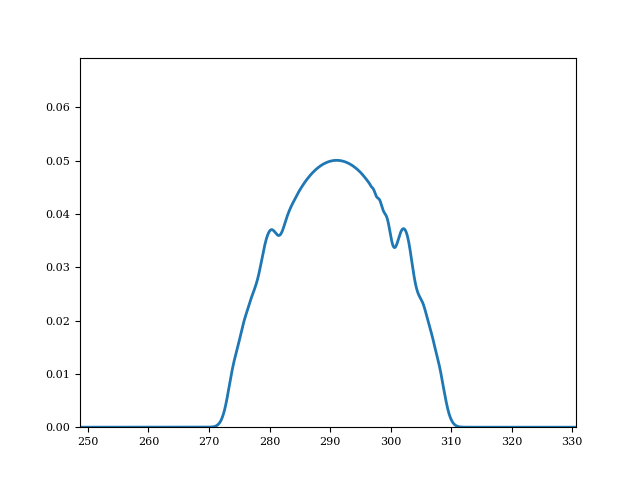

In [7]:
domain = Domain(samples_per_bit=2**14, bit_width=200.0,
                total_bits=1, centre_nu=lambda_to_nu(1035))

new_result = get_laser_info(df_test_graphs, domain, "cycle9", get_caption(
    lasers_params[i]), path_to_graphs[i], False)

In [ ]:
domain = Domain(samples_per_bit=2**14, bit_width=200.0,
                total_bits=1, centre_nu=lambda_to_nu(1035))
last_cycle = df_test_graphs.index.get_level_values('cycle').values[-1]
z_output = df_test_graphs.index.get_level_values('z [mm]').values[-1]
last_fibre = df_test_graphs.loc[(last_cycle, "5_active_fibre")]
z_output = last_fibre.index.get_level_values('z [mm]').values[-1]
output_field = last_fibre.loc[(z_output)]

heigth_fwhm, fwhm, left_ind, right_ind = spectrum_width_params(output_field)
x = domain.nu
plt.clf()
plt.figure()
plt.plot(x, output_field)
plt.hlines(heigth_fwhm, x[int(left_ind)], x[int(right_ind)], color="C2")
plt.show()

[7976 8291 8470 8640 8960]
[7976 8291 8470 8640 8960]



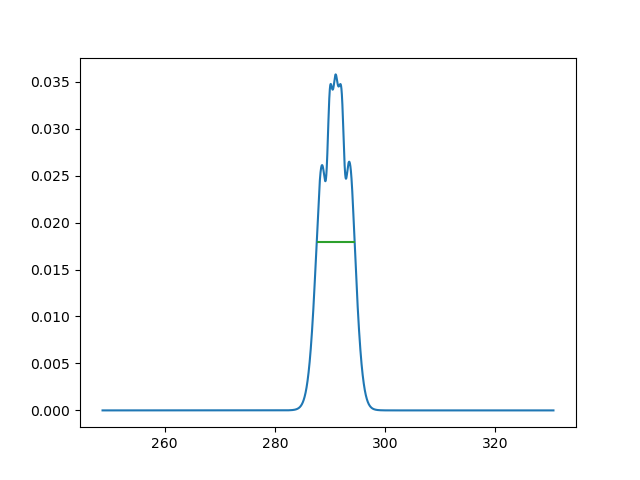

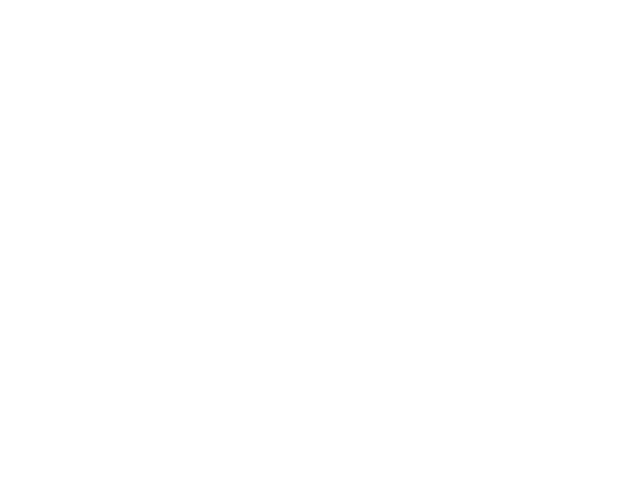

In [18]:
from scipy import optimize
%matplotlib widget


domain = Domain(samples_per_bit=2**14, bit_width=200.0,
                total_bits=1, centre_nu=lambda_to_nu(1035))

df = df_test_graphs.loc[("cycle9", "5_active_fibre")]

z = df.index.get_level_values('z [mm]').values[50]
x = domain.nu
P = df.loc[(z)]
# plt.plot(domain.nu, P)
peaks, _ = find_peaks(P, height=0, prominence=0.0001)
results_fwhm = peak_widths(P, [peaks[0], peaks[1]], rel_height=0.5)
heigth_fwhm = np.amax(P)/2
peaks.sort()
print(peaks)
print(peaks)
print()
heigth_fwhm, fwhm, left_ind, right_ind = spectrum_width_params(P)

plt.clf()
plt.figure()
plt.plot(x, P)
plt.hlines(heigth_fwhm, x[int(left_ind)], x[int(right_ind)], color="C2")

plt.show()

In [20]:
df_test_energy = pd.read_csv(lasers_temp_files[0], index_col=[0, 1, 2])

In [100]:
path_to_results = path_to_graphs[0]
cycle_names = list(set(df_test_energy.index.get_level_values('cycle').values))
cycle_names.sort()
df_test_energy.loc[(cycle_names[-1])].to_csv(os.path.join(path_to_results, "last_cycle.csv"))

In [103]:
df_last_cycle = pd.read_csv(os.path.join(path_to_results,  "last_cycle.csv"), index_col=[0, 1])

In [104]:
df_last_cycle

0             1             2  \
fibre           z [mm]                                              
1_passive_fibre 46800.0  1.688603e-25  1.607087e-25  1.412070e-25   
                46810.0  1.654462e-25  1.591921e-25  1.353086e-25   
                46820.0  1.693250e-25  1.570567e-25  1.433234e-25   
                46830.0  1.672953e-25  1.722241e-25  1.427838e-25   
                46840.0  1.790288e-25  1.631562e-25  1.417236e-25   
...                               ...           ...           ...   
6_passive_fibre 51960.0  7.291090e-19  7.190661e-19  7.276648e-19   
                51970.0  9.387395e-19  9.617587e-19  9.382599e-19   
                51980.0  1.196943e-18  1.211000e-18  1.198336e-18   
                51990.0  1.485225e-18  1.456713e-18  1.483792e-18   
                52000.0  1.741966e-18  1.720937e-18  1.737804e-18   

                                    3             4             5  \
fibre           z [mm]                                              
1_passive_fibre 46800.0  1.213557e-25  1.123289e-25  9.818979e-26   
                46810.0  1.315599e-25  1.167041e-25  1.035183e-25   
                46820.0  1.336804e-25  1.112893e-25  1.049260e-25   
                46830.0  1.216810e-25  1.143188e-25  1.056575e-25   
                46840.0  1.347035e-25  1.022413e-25  1.033916e-25   
...                               ...           ...           ...   
6_passive_fibre 51960.0  7.198049e-19  7.279155e-19  7.222683e-19   
                51970.0  9.614161e-19  9.375003e-19  9.623243e-19   
                51980.0  1.210184e-18  1.199708e-18  1.207874e-18   
                51990.0  1.456710e-18  1.485675e-18  1.455490e-18   
                52000.0  1.723311e-18  1.737756e-18  1.722646e-18   

                                    6             7             8  \
fibre           z [mm]                                              
1_passive_fibre 46800.0  9.642927e-26  8.826824e-26  7.540215e-26   
                46810.0  9.321620e-26  8.756041e-26  7.892396e-26   
                46820.0  9.958514e-26  8.512440e-26  8.014373e-26   
                46830.0  9.468939e-26  1.043113e-25  7.983351e-26   
                46840.0  1.133937e-25  8.506938e-26  8.549122e-26   
...                               ...           ...           ...   
6_passive_fibre 51960.0  7.233739e-19  7.248201e-19  7.232950e-19   
                51970.0  9.357607e-19  9.630376e-19  9.396910e-19   
                51980.0  1.200916e-18  1.205943e-18  1.205298e-18   
                51990.0  1.486684e-18  1.456799e-18  1.484948e-18   
                52000.0  1.736058e-18  1.727565e-18  1.731815e-18   

                                    9  ...         16374         16375  \
fibre           z [mm]                 ...                               
1_passive_fibre 46800.0  7.912612e-26  ...  5.606700e-25  4.740984e-25   
                46810.0  7.486290e-26  ...  5.395872e-25  4.817176e-25   
                46820.0  8.095685e-26  ...  5.376694e-25  4.635359e-25   
                46830.0  7.008240e-26  ...  5.178416e-25  4.503454e-25   
                46840.0  8.264186e-26  ...  4.989135e-25  4.474195e-25   
...                               ...  ...           ...           ...   
6_passive_fibre 51960.0  7.242999e-19  ...  7.299993e-19  7.174173e-19   
                51970.0  9.580306e-19  ...  9.379717e-19  9.615182e-19   
                51980.0  1.200711e-18  ...  1.195066e-18  1.214019e-18   
                51990.0  1.456946e-18  ...  1.484649e-18  1.456176e-18   
                52000.0  1.731679e-18  ...  1.744489e-18  1.715539e-18   

                                16376         16377         16378  \
fibre           z [mm]                                              
1_passive_fibre 46800.0  4.351615e-25  3.958048e-25  3.495333e-25   
                46810.0  4.138097e-25  3.575698e-25  3.269199e-25   
                46820.0  4.012012e-25  3.479998e-25  3.106259e-25   
                46830.0  3.954933e

0.999992990399673
0.0007009600326946191 %


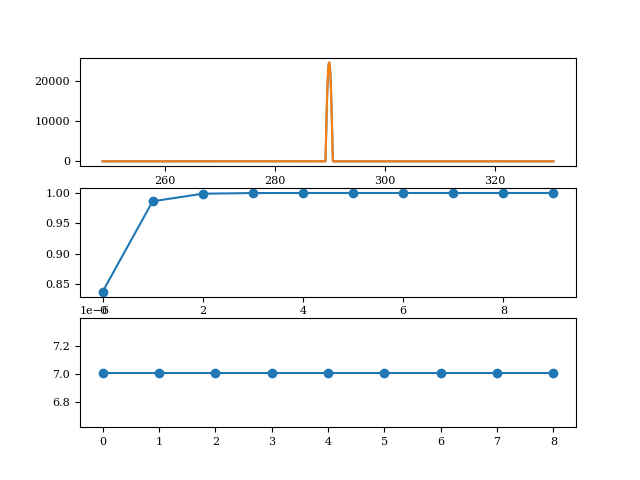

In [112]:
domain = Domain(samples_per_bit=2**14, bit_width=200.0,
                total_bits=1, centre_nu=lambda_to_nu(1035))


cycle_names = list(set(df_test_energy.index.get_level_values('cycle').values))
cycle_names.sort()
output_field_last = get_output_field(df_test_energy, cycle_names[9])
output_field_prev = get_output_field(df_test_energy, cycle_names[8])
heigth_fwhm, fwhm, left_ind, right_ind = spectrum_width_params(output_field_last)
x = domain.nu

fig, ax = plt.subplots(2, 1)
ax[0].plot(x, output_field_last)
ax[0].plot(x, output_field_prev)
E_last = np.amax(output_field_last)
E_prev = np.amax(output_field_prev)
print(E_last/E_prev)
print(f"{(abs(E_last - E_prev)/E_prev)*100} %")
# plt.hlines(heigth_fwhm, x[int(left_ind)], x[int(right_ind)], color="C2")

x = np.arange(len(cycle_names))
y = np.zeros(len(x))
relation = np.zeros(len(x)-1)
relation_x = np.arange(len(cycle_names)-1)
for i in range(len(cycle_names)):
    y[i] = np.amax(get_output_field(df_test_energy, cycle_names[i]))
    if (i > 0):
        relation[i-1] = (abs(E_last - E_prev)/E_prev)

y = y / np.amax(y)  
ax[1].plot(x, y)
ax[1].scatter(x, y)

plt.show()

df_results = pd.DataFrame()

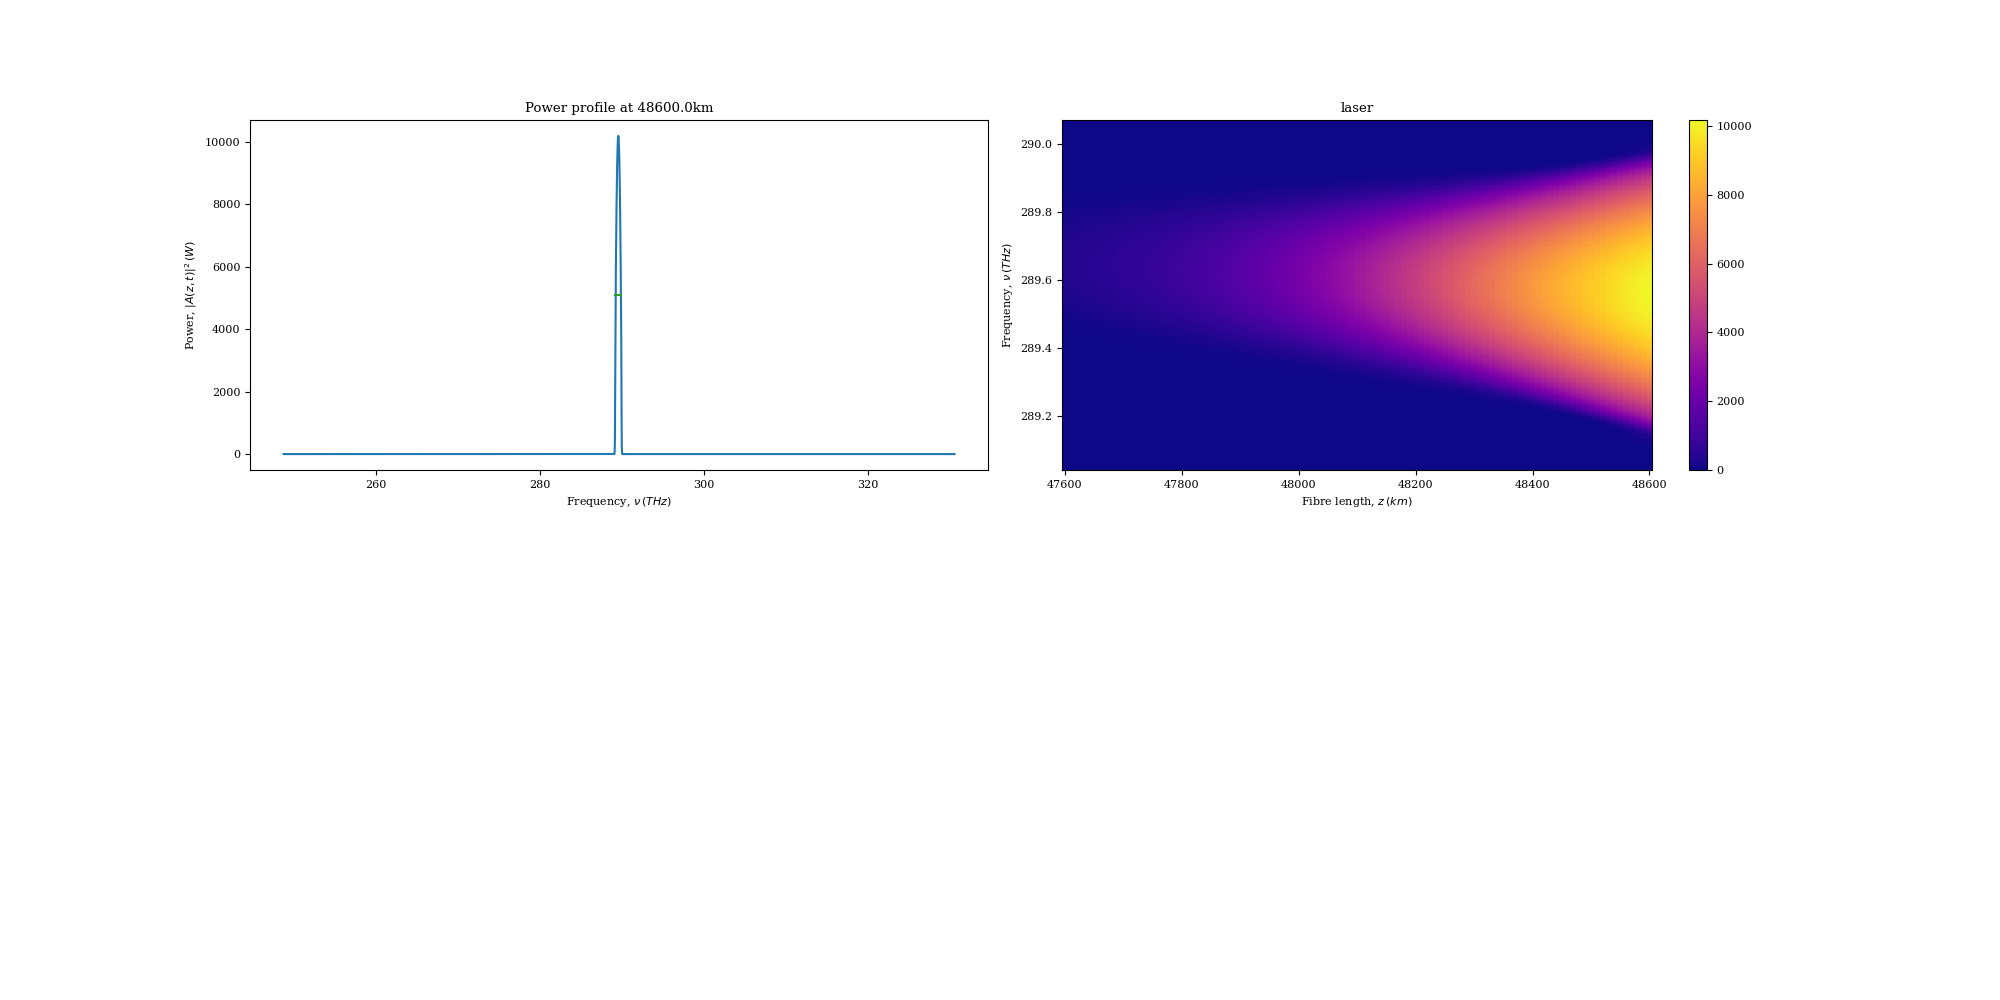

In [106]:
fig = plt.figure(figsize=(20, 10))
outer = gridspec.GridSpec(2, 1, wspace=0.1, hspace=0.2)
draw_heat_map(df_last_cycle.loc[("2_active_fibre")], domain,
              is_temporal=False, prominence=0.001, title="laser", subplot_spec=outer[0], fig=fig)


In [ ]:
fig = plt.figure(figsize=(20, 10))
outer = gridspec.GridSpec(2, 1, wspace=0.1, hspace=0.2) 
draw_heat_map(df_test_graphs.loc[("cycle0", "2_active_fibre")], domain, is_temporal=False, prominence=0.1, title="laser", subplot_spec=outer[0], fig=fig)

In [ ]:
# def visualize(result_dir, subplot_spec=None, fig=None, title = None, ):
#     z_start = 0
#     i = 4
#     fibre_dir = os.path.join(result_dir, f'cycle{int(i)}', 'active_fibre_2')
#     storage = Storage(fibre_dir)
#     plt_data = storage.read_all_from_dir(is_temporal=True)
#     plotter = FibrePlotter(*plt_data, labels["t"], labels["P_t"], labels["z"])
#     z_start = plotter.draw_heat_map(z_start, prominence=0.05, subplot_spec=subplot_spec, fig=fig, title=title, vmin=0)

# def read_as_df_all(result_dir):
#     cycle_dir_list = os.listdir(result_dir)
#     df_all = pd.DataFrame()
#     z_curr = 0
#     for i in range(len(cycle_dir_list)):
#         dir_name= os.path.join(result_dir, cycle_dir_list[i], "temp")
#         if os.path.exists(dir_name):
#             fibre_list = os.listdir(dir_name)
#             for j in range(len(fibre_list)):
#                 fibre_file_name = os.path.join(os.path.join(result_dir, cycle_dir_list[i], "temp", fibre_list[j]))
#                 df_fibre = pd.read_csv(fibre_file_name, index_col=[0])
#                 iterables = [[cycle_dir_list[i]], [fibre_list[j]], df_fibre.index.values + z_curr]
#                 z_curr +=  df_fibre.index.values[-1]
#                 index = pd.MultiIndex.from_product(iterables, names=["cycle","fibre","z [mm]"])
#                 df_new = pd.DataFrame(df_fibre.values, index=index)
#                 df_all = pd.concat([df_all, df_new])
#     return df_all

# def draw_peak_power(result_dir, N_cycles):
#     z_start = 0
#     for i in range(N_cycles):
#         cycle_dir = os.path.join(result_dir, f'cycle{int(i)}')
#         fibre_dir_list = os.listdir(cycle_dir)
#         for i in range(len(fibre_dir_list)):
#             fibre_dir = os.path.join(cycle_dir, fibre_dir_list[i])
#             storage = Storage(fibre_dir)
#             plt_data = storage.read_all_from_dir(is_temporal=True)
#             plotter = FibrePlotter(*plt_data, labels["t"], labels["P_t"], labels["z"])
#             z_start+=plotter.draw_peak_power(z_start)
